# Variational autoencoder: generating MNIST data

On this notebook we will cover the training of a VAE on the MNIST dataset, and we will cover the next topics:
- Model architecture: 
    - Encoder and Decoder
    - Reconstruction loss and Kulback-Leibler loss
    - Reparametrization Trick
### The dataset: MNIST

We have already worked on this dataset, which essentially consists of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
# from config import *

For this model example, we will not be taking into account the whole image structure. Instead, for simplicity, we will consider each image as a 28*28=784 dimension vector

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

<font color=red> bound the data to [0,1]
</font>

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
# input shape dim
input_shape = (original_dim, )

In [6]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

### The encoder and the decoder. Reparametrization trick.

We will create both the encoder and teh decoder with a pretty simple architecture. The sampling function will provide, given the mean and variance of the encoded data, a sampled latent vector inside the latent space.

**Please note n practice, however, it’s better to model variance as log (variance), as it is more numerically stable to take exponent compared to computing log. **

In [7]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] 
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [8]:
# build encoder model
def encoder_model(inputs):
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder, z_mean, z_log_var


In [9]:
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

### Decoder Architecture
<font color=red> Build the Decoder model (in the functorial way) to be trained on the data</font>, with this config:
- Input layer with (latent_dim, )for the shape
- Dense layer with intermediate_dim units and relu activated
- Dense layer with original_dim units and sigmoid activated
- Model layer with the latent inputs and the outputs.

- Please name the first layer as 'z_sampling' and the Model one as 'decoder'


In [10]:
# build decoder model
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder


In [11]:
decoder = decoder_model()
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


We will define the outputs as the Dec(Enc(inputs)), and will build the VAE as a model of the inputs and outputs:

In [12]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


## The Loss Function


$$\mathcal{L} = \alpha\cdot MSE(inputs, outputs) + \beta\cdot KL(N(0,1), 
N(\mu_z,\sigma_z))$$
where
$$KL(N(0,1), N(\mu_z,\sigma_z))= 0.5 * \sum exp(log(\sigma_z)) + \mu_z^2 - 1 - log(\sigma_z)$$

We will use $\alpha=original_{dim}$ and $\beta=1$

In [13]:
# reconstruction loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

In [14]:
# KL loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

Finally, we will take the mean of both losses and add it to the VAE:

In [15]:
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

<font color=red> Train the vae, using x_test as the validation data </font>

In [ ]:
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
# vae.save_weights('vae_mlp_mnist_latent_dim_%s.h5' %latent_dim)
# vae.load_weights('vae_mlp_mnist_latent_dim_2.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 15s 258us/sample - loss: 51.8448 - val_loss: 43.9985
Epoch 2/50
60000/60000 [==============================] - 14s 234us/sample - loss: 43.4331 - val_loss: 42.7508
Epoch 3/50
60000/60000 [==============================] - 14s 235us/sample - loss: 42.4198 - val_loss: 41.9526
Epoch 4/50
60000/60000 [==============================] - 14s 236us/sample - loss: 41.7618 - val_loss: 41.5207
Epoch 5/50
60000/60000 [==============================] - 14s 238us/sample - loss: 41.2396 - val_loss: 41.0766
Epoch 6/50
52352/60000 [=========================>....] - ETA: 1s - loss: 40.8182

### Results visualization

Let's first display a 2D plot of the digit classes in the latent space. Let's remember the latent space is of dimension 2. So, we can display a visualization of it qith the different classses represented as colors:

Text(0, 0.5, 'Dimension 2')

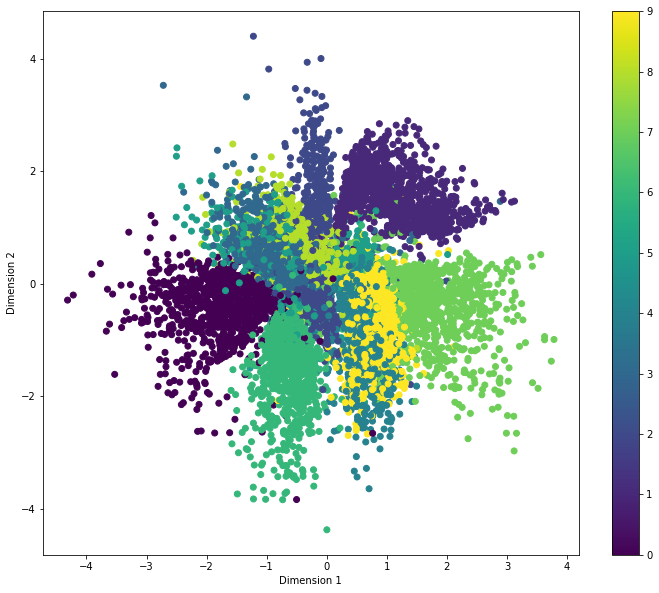

In [16]:
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")


#### Reconstruction plot
Let's now plot an image and its reconstruction:

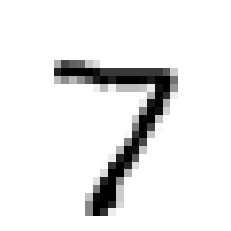

In [17]:
def plot_mnist_sample(mnist_vector):
    plt.ioff()
    img = np.reshape(mnist_vector, (image_size, image_size))
    plt.axis('off')
    plt.imshow(img, cmap = 'gray_r')
plot_mnist_sample(x_test[0])

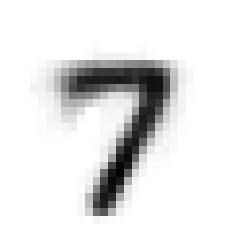

In [18]:
def plot_reconstructed (mnist_original_vector):
    encoder_input = np.expand_dims(mnist_original_vector, axis = 0)
    mean, var, z = encoder.predict(encoder_input)
    decoded_output = decoder.predict(mean)
    plot_mnist_sample(decoded_output)
plot_reconstructed (x_test[0])

<font color=red> Plot the first 30 examples and their reconstruction on the test dataset </font>

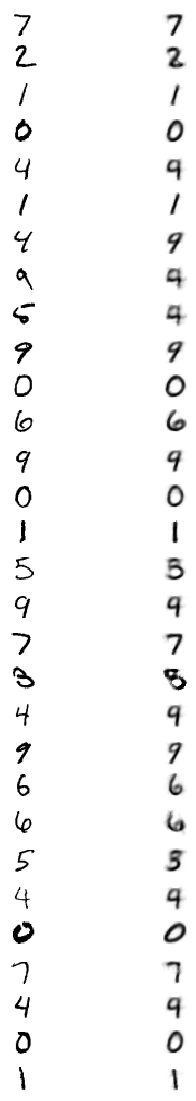

In [19]:
plt.ioff()
plt.figure(figsize=(5, 20))
for i in range(30):
    plt.subplot(30, 2, 2*i+1)
    plot_mnist_sample(x_test[i])

    plt.subplot(30, 2, 2*i + 2)
    plot_reconstructed(x_test[i])

## Data generation
Now let's generate images from data.

<font color=red> Generate and Plot some data examples </font>

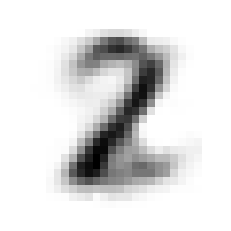

In [20]:
mean = [0,0]
var = [1, 1]

random_example = np.expand_dims(np.random.normal(mean, var), axis = 0)
decoded_output = decoder.predict(random_example)
plot_mnist_sample(decoded_output)

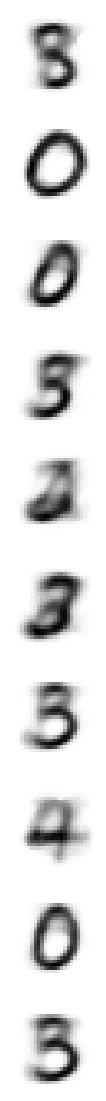

In [21]:
plt.ioff()
plt.figure(figsize=(10, 20))
for i in range(10):
    plt.subplot(10, 2, 2*i+1)
    random_example = np.expand_dims(np.random.normal(mean, var), axis = 0)
    decoded_output = decoder.predict(random_example)
    plot_mnist_sample(decoded_output)

Finally, let's display a grid of generated images. <font color=red> What does it mean? </font>

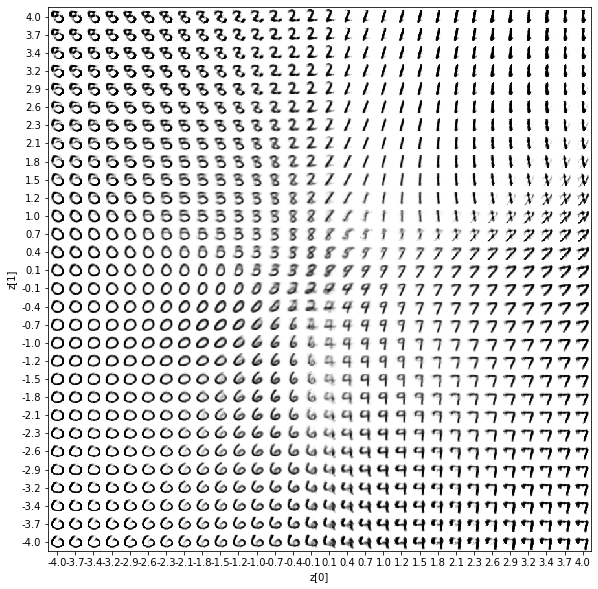

In [22]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='gray_r')
